In [28]:
import torch
from torch import nn

from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scipy

import openml
import onnx
import copy

Download CERN data from [here](https://www.openml.org/search?type=data&sort=qualities.NumberOfClasses&status=active&qualities.NumberOfFeatures=between_10_100&qualities.NumberOfClasses=gte_2&qualities.NumberOfInstances=between_100000_1000000&id=42468)

In [43]:
dataset = openml.datasets.get_dataset('hls4ml_lhc_jets_hlf')

/tmp/ipykernel_719757/3061338720.py:1: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = openml.datasets.get_dataset('hls4ml_lhc_jets_hlf')


In [44]:
X, y, cats, attr = dataset.get_data(dataset_format='dataframe', target=dataset.default_target_attribute)

In [45]:
X

zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0      -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1      -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2      -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3      -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4      -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   
...          ...         ...         ...         ...         ...         ...   
829995 -3.575320    0.473246    0.040693    0.005605    0.053711    0.004402   
829996 -2.408292    0.429539    0.040022    0.005620    0.020352    0.000804   
829997 -3.338864    0.467011    0.075235    0.017644    0.097954    0.022681   
829998 -1.535967    0.335411    0.002537    0.000021    0.002692    0.000017   
829999 -2.987995    0.455648    0.005218    0.000073    0.006994    0.000099   

        d2_b1_mmdt  d2_b2_mmdt  d2_a1_b1_mmdt  d2_a1_b2_mmdt  m2_b1_mmdt  \
0         1.769445    2.123898       1.769445       0.308185    0.135687   
1         2.038834    2.563099       2.038834       0.211886    0.063729   
2         1.269254    1.346238       1.269254       0.246488    0.115636   
3         0.966505    0.601864       0.966505       0.160756    0.082196   
4         0.552002    0.183821       0.552002       0.084338    0.048006   
...            ...         ...            ...            ...         ...   
829995    1.319914    0.785488       1.319914       0.211968    0.106151   
829996    0.508506    0.143106       0.508506       0.077383    0.043065   
829997    1.301970    1.285501       1.301970       0.236583    0.110919   
829998    1.061160    0.797847       1.061160       0.175014    0.086063   
829999    1.340265    1.357867       1.340265       0.305734    0.158129   

        m2_b2_mmdt  n2_b1_mmdt  n2_b2_mmdt   mass_mmdt  multiplicity  
0         0.083278    0.412136    0.299058    8.926882            75  
1         0.036310    0.310217    0.226661    3.886512            31  
2         0.079094    0.357559    0.289220  162.144669            61  
3         0.033311    0.238871    0.094516   91.258934            39  
4         0.014450    0.141906    0.036665   79.725777            35  
...            ...         ...         ...         ...           ...  
829995    0.037546    0.315867    0.123637   72.537308            71  
829996    0.011398    0.131738    0.028787   77.263367            30  
829997    0.068624    0.307230    0.183485  136.165955            72  
829998    0.048476    0.271106    0.161818    4.660848            11  
829999    0.092861    0.397832    0.257965   11.555076            42  

[830000 rows x 16 columns]

In [46]:
outliers = (np.abs(scipy.stats.zscore(X)) < 2).all(axis=1)
print("Number of samples before: ", len(X))
X = X[outliers]
print("Number of samples after: ", len(X))
y = y[outliers]

Number of samples before:  830000
Number of samples after:  592321


## Prepare Data

In [47]:
def map_label(y):
  if y == 'g':
    return 0
  elif y == 'w':
    return 1
  elif y == 't':
    return 2
  elif y == 'z':
    return 3
  elif y == 'q':
    return 4
  else:
    raise ValueError('Invalid label')

In [48]:
map_labels = np.vectorize(map_label)
y = map_labels(y)

In [49]:
# Split X,y into training and testing datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
mu = X_train.to_numpy().mean(axis=0)
sigma = X_train.to_numpy().std(axis=0)

print(mu)
print(sigma)

[-2.85230223e+00  4.40114055e-01  3.34429923e-02  5.81976863e-03
  3.73580517e-02  4.09355687e-03  1.21745083e+00  9.15087138e-01
  1.21745083e+00  1.80330558e-01  8.69715629e-02  3.85062382e-02
  2.69746842e-01  1.27510770e-01  6.75134378e+01  4.81897834e+01]
[4.58589097e-01 3.53359808e-02 2.10735762e-02 5.57128330e-03
 2.53089574e-02 5.43326611e-03 3.93313550e-01 5.92509532e-01
 3.93313550e-01 7.20393875e-02 3.46199762e-02 2.48932859e-02
 8.04752254e-02 7.51266567e-02 4.19531100e+01 1.66943302e+01]


In [51]:
X_train = (X_train.to_numpy() - mu) / sigma
X_test = (X_test.to_numpy() - mu) / sigma

In [52]:
generator1 = torch.Generator().manual_seed(42)
ds_train = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train))
ds_test = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test))

# Training Loop

In [53]:
def train_loop(model, epochs=10):
  model = model.to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  train_loader = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True)
  test_loader = torch.utils.data.DataLoader(ds_test, batch_size=32, shuffle=True)

  for epoch in range(1, epochs+1):
    train_loss = 0
    test_loss = 0
    train_acc = 0
    test_acc = 0

    model.train()
    for batch, (X, y) in enumerate(train_loader):
      X = X.to(device)
      y = y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      train_acc += (y_pred.argmax(1) == y).type(torch.float).sum().item()

    model.eval()
    for batch, (X, y) in enumerate(test_loader):
      X = X.to(device)
      y = y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred, y)

      test_loss += loss.item()
      test_acc += (y_pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    train_acc /= len(ds_train)
    test_acc /= len(ds_test)
    print(f'Epoch {epoch} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}')

In [78]:
model2x20 = nn.Sequential(
    nn.Linear(16, 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.Softmax()
)

In [89]:
model4x20 = nn.Sequential(
    nn.Linear(16, 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.Softmax()
)

In [80]:
model2x40 = nn.Sequential(
    nn.Linear(16, 40),
    nn.ReLU(),
    nn.Linear(40, 40),
    nn.ReLU(),
    nn.Linear(40, 5),
    nn.Softmax()
)

In [81]:
model2x80 = nn.Sequential(
    nn.Linear(16, 80),
    nn.ReLU(),
    nn.Linear(80, 80),
    nn.ReLU(),
    nn.Linear(80, 5),
    nn.Softmax()
)

# Pruning

In [82]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [83]:
from torch.nn.utils import prune
def move_bias_to_next_layer(layer, next_layer):
    zero_indices = torch.where(~layer.weight.any(axis=1))[0]
    next_layer.bias += next_layer.weight[:,zero_indices] @ layer.bias[zero_indices]
    layer.bias[zero_indices] = 0.0
def generate_pruned(model, name, num_epochs = 5, key="", kl=False):
    name += key
    # Remove the dropout layers
    layers = [l for l in model if type(l) != nn.Dropout]
    model = nn.Sequential(*layers)
    torch.save(model.state_dict(), f"lhc/nets/{name}.pt")
    torch_input = torch.zeros(1, 16)
    torch.onnx.export(model, torch_input.to(device), f"lhc/nets/{name}.onnx", input_names=['X'], output_names=['y_out'])

    train_loader = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(ds_test, batch_size=32, shuffle=True)

    for pruning_factor in [0.1,0.2,0.3,0.4,0.5]:
        print(f"Pruning {pruning_factor}")
        #net = torch.load(f"{name}.pt",weights_only=False)
        net = copy.deepcopy(model)
        net.load_state_dict(torch.load(f"lhc/nets/{name}.pt", weights_only=True))

        layers = [l for l in net]
        for i in range(len(layers)):
            if type(layers[i]) == nn.Linear and i+2 < len(layers) and type(layers[i+2])==nn.Linear:
                layers[i] = prune.ln_structured(layers[i], "weight", amount=pruning_factor, n=float('-inf'), dim=0)
                with torch.no_grad():
                    move_bias_to_next_layer(layers[i], layers[i+2])
        net_pruned = nn.Sequential(*layers)
        net_pruned.to(device)
        model.to(device)
        print(net_pruned)

        # Retrain the network
        net_pruned.train()
        optimizer = torch.optim.Adam(net_pruned.parameters(), lr=0.001)
        if kl:
            criterion = nn.KLDivLoss()
        else:
            criterion = nn.MSELoss()
        share = 1.0
        if type(num_epochs) == float:
            full_epochs = int(num_epochs)
            share = num_epochs - full_epochs
            num_epochs = full_epochs + 1
        else:
            full_epochs = num_epochs
        for epoch in range(num_epochs):
            workshare = 0.0
            for inputs, _ in train_loader:
                if epoch == full_epochs:
                    workshare += 32/len(ds_train)
                    if workshare > share:
                        break
                optimizer.zero_grad()
                outputs = net_pruned(inputs.to(device))
                targets = model(inputs.to(device))
                loss = criterion(outputs, targets)
                loss.backward()
                # Maybe not necessary?
                # for p in net_pruned.parameters():
                #     p.grad[p.data == 0.0] = 0.0
                optimizer.step()

        net_pruned.eval()
        test_loss = 0.0
        test_acc = 0.0
        for batch, (X, y) in enumerate(test_loader):
            y = y.to(device)
            X = X.to(device)
            y_pred = net_pruned(X)
            targets = model(X.to(device))
            loss = criterion(y_pred, targets)

            test_acc += (y_pred.argmax(1) == y).type(torch.float).sum().item()
            test_loss += loss.item()

        test_loss /= len(ds_test)
        test_acc /= len(ds_test)
        print(f'Loss: {test_loss}; Acc: {test_acc}')
        torch.onnx.export(net_pruned, torch_input.to(device), f"lhc/nets_pruned/{name}-{pruning_factor}.onnx", input_names=['X'], output_names=['y_out'])

## Model 2x20

In [84]:
train_loop(model2x20, epochs=10)

Epoch 1 | Train Loss: 1.2008 | Test Loss: 1.1679 | Train Acc: 0.7045 | Test Acc: 0.7344
Epoch 2 | Train Loss: 1.1637 | Test Loss: 1.1591 | Train Acc: 0.7385 | Test Acc: 0.7424
Epoch 3 | Train Loss: 1.1600 | Test Loss: 1.1598 | Train Acc: 0.7418 | Test Acc: 0.7418
Epoch 4 | Train Loss: 1.1585 | Test Loss: 1.1576 | Train Acc: 0.7433 | Test Acc: 0.7442
Epoch 5 | Train Loss: 1.1576 | Test Loss: 1.1578 | Train Acc: 0.7441 | Test Acc: 0.7444
Epoch 6 | Train Loss: 1.1569 | Test Loss: 1.1562 | Train Acc: 0.7451 | Test Acc: 0.7460
Epoch 7 | Train Loss: 1.1565 | Test Loss: 1.1567 | Train Acc: 0.7454 | Test Acc: 0.7448
Epoch 8 | Train Loss: 1.1560 | Test Loss: 1.1568 | Train Acc: 0.7459 | Test Acc: 0.7447
Epoch 9 | Train Loss: 1.1555 | Test Loss: 1.1557 | Train Acc: 0.7464 | Test Acc: 0.7460
Epoch 10 | Train Loss: 1.1550 | Test Loss: 1.1544 | Train Acc: 0.7469 | Test Acc: 0.7478


Accuracy:  0.7478411345123032


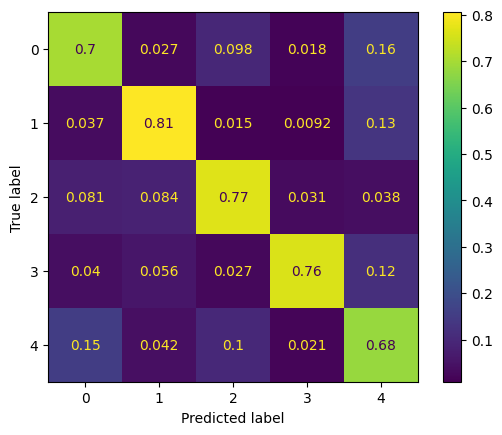

In [86]:
y_pred = model2x20(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().detach().numpy()
print("Accuracy: ",(y_pred.argmax(1) == y_test).sum().item() / len(y_test))
cm = confusion_matrix(y_test, y_pred.argmax(1), normalize='true')
ConfusionMatrixDisplay(cm).plot()

In [87]:
generate_pruned(model2x20, "2_20", 0.1, "-0.1")

/home/samuel/anaconda3/envs/neurodiff/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return forward_call(*args, **kwargs)
/home/samuel/anaconda3/envs/neurodiff/lib/python3.8/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Pruning 0.1
Sequential(
  (0): Linear(in_features=16, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=5, bias=True)
  (5): Softmax(dim=None)
)
Loss: 2.950489565401094e-05; Acc: 0.7462204026505719
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Pruning 0.2
Sequential(
  (0): Linear(in_features=16, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=5, bias=True)
  (5): Softmax(dim=None)
)
Loss: 0.00013679216195190921; Acc: 0.74

In [88]:
generate_pruned(model2x20, "2_20", 1, "-1")

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Pruning 0.1
Sequential(
  (0): Linear(in_features=16, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=5, bias=True)
  (5): Softmax(dim=None)
)
Loss: 1.3988199737474028e-05; Acc: 0.7469463554636391
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Pruning 0.2
Sequential(
  (0): Linear(in_features=16, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=5, bias=True)
  (5): Softmax(dim=None)
)
Loss: 0.001969795877332169; Acc: 0.563

## Model 2x40

In [93]:
train_loop(model2x40, epochs=10)

Epoch 1 | Train Loss: 1.1829 | Test Loss: 1.1641 | Train Acc: 0.7208 | Test Acc: 0.7376
Epoch 2 | Train Loss: 1.1607 | Test Loss: 1.1609 | Train Acc: 0.7412 | Test Acc: 0.7407
Epoch 3 | Train Loss: 1.1586 | Test Loss: 1.1576 | Train Acc: 0.7430 | Test Acc: 0.7439
Epoch 4 | Train Loss: 1.1574 | Test Loss: 1.1591 | Train Acc: 0.7443 | Test Acc: 0.7428
Epoch 5 | Train Loss: 1.1564 | Test Loss: 1.1535 | Train Acc: 0.7453 | Test Acc: 0.7486
Epoch 6 | Train Loss: 1.1554 | Test Loss: 1.1524 | Train Acc: 0.7462 | Test Acc: 0.7495
Epoch 7 | Train Loss: 1.1540 | Test Loss: 1.1546 | Train Acc: 0.7477 | Test Acc: 0.7472
Epoch 8 | Train Loss: 1.1534 | Test Loss: 1.1519 | Train Acc: 0.7482 | Test Acc: 0.7499
Epoch 9 | Train Loss: 1.1529 | Test Loss: 1.1522 | Train Acc: 0.7488 | Test Acc: 0.7493
Epoch 10 | Train Loss: 1.1526 | Test Loss: 1.1524 | Train Acc: 0.7493 | Test Acc: 0.7496


Accuracy:  0.7495631621153928


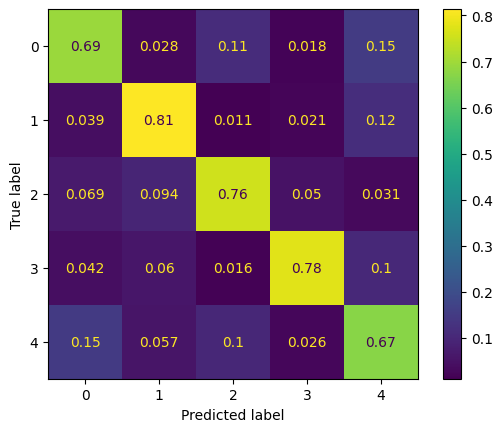

In [94]:
y_pred = model2x40(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().detach().numpy()
print("Accuracy: ",(y_pred.argmax(1) == y_test).sum().item() / len(y_test))
cm = confusion_matrix(y_test, y_pred.argmax(1), normalize='true')
ConfusionMatrixDisplay(cm).plot()

In [95]:
generate_pruned(model2x40, "2_40", 0.1, "-0.1")

/home/samuel/anaconda3/envs/neurodiff/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return forward_call(*args, **kwargs)
/home/samuel/anaconda3/envs/neurodiff/lib/python3.8/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Pruning 0.1
Sequential(
  (0): Linear(in_features=16, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=40, bias=True)
  (3): ReLU()
  (4): Linear(in_features=40, out_features=5, bias=True)
  (5): Softmax(dim=None)
)
Loss: 4.620055018521406e-05; Acc: 0.7489722702908032
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Pruning 0.2
Sequential(
  (0): Linear(in_features=16, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=40, bias=True)
  (3): ReLU()
  (4): Linear(in_features=40, out_features=5, bias=True)
  (5): Softmax(dim=None)
)
Loss: 6.306095062863604e-05; Acc: 0.748

In [96]:
generate_pruned(model2x40, "2_40", 1, "-1")

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Pruning 0.1
Sequential(
  (0): Linear(in_features=16, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=40, bias=True)
  (3): ReLU()
  (4): Linear(in_features=40, out_features=5, bias=True)
  (5): Softmax(dim=None)
)
Loss: 3.305089121429585e-05; Acc: 0.7495293968682734
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Pruning 0.2
Sequential(
  (0): Linear(in_features=16, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=40, bias=True)
  (3): ReLU()
  (4): Linear(in_features=40, out_features=5, bias=True)
  (5): Softmax(dim=None)
)
Loss: 4.760372229110917e-05; Acc: 0.749

## Model 4x80

In [97]:
train_loop(model2x80, epochs=10)

Epoch 1 | Train Loss: 1.1782 | Test Loss: 1.1612 | Train Acc: 0.7251 | Test Acc: 0.7403
Epoch 2 | Train Loss: 1.1614 | Test Loss: 1.1581 | Train Acc: 0.7405 | Test Acc: 0.7434
Epoch 3 | Train Loss: 1.1589 | Test Loss: 1.1555 | Train Acc: 0.7430 | Test Acc: 0.7464
Epoch 4 | Train Loss: 1.1572 | Test Loss: 1.1572 | Train Acc: 0.7446 | Test Acc: 0.7448
Epoch 5 | Train Loss: 1.1560 | Test Loss: 1.1524 | Train Acc: 0.7459 | Test Acc: 0.7498
Epoch 6 | Train Loss: 1.1542 | Test Loss: 1.1564 | Train Acc: 0.7476 | Test Acc: 0.7456
Epoch 7 | Train Loss: 1.1538 | Test Loss: 1.1526 | Train Acc: 0.7479 | Test Acc: 0.7491
Epoch 8 | Train Loss: 1.1529 | Test Loss: 1.1552 | Train Acc: 0.7489 | Test Acc: 0.7467
Epoch 9 | Train Loss: 1.1526 | Test Loss: 1.1532 | Train Acc: 0.7494 | Test Acc: 0.7481
Epoch 10 | Train Loss: 1.1518 | Test Loss: 1.1508 | Train Acc: 0.7500 | Test Acc: 0.7510


Accuracy:  0.7509644198708479


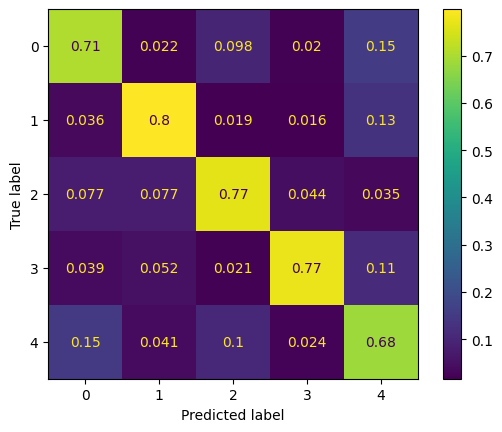

In [98]:
y_pred = model2x80(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().detach().numpy()
print("Accuracy: ",(y_pred.argmax(1) == y_test).sum().item() / len(y_test))
cm = confusion_matrix(y_test, y_pred.argmax(1), normalize='true')
ConfusionMatrixDisplay(cm).plot()

In [99]:
generate_pruned(model2x80, "2_80", 0.1, "-0.1")

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Pruning 0.1
Sequential(
  (0): Linear(in_features=16, out_features=80, bias=True)
  (1): ReLU()
  (2): Linear(in_features=80, out_features=80, bias=True)
  (3): ReLU()
  (4): Linear(in_features=80, out_features=5, bias=True)
  (5): Softmax(dim=None)
)


/home/samuel/anaconda3/envs/neurodiff/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return forward_call(*args, **kwargs)
/home/samuel/anaconda3/envs/neurodiff/lib/python3.8/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss: 9.302710064669641e-05; Acc: 0.7493858945680159
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Pruning 0.2
Sequential(
  (0): Linear(in_features=16, out_features=80, bias=True)
  (1): ReLU()
  (2): Linear(in_features=80, out_features=80, bias=True)
  (3): ReLU()
  (4): Linear(in_features=80, out_features=5, bias=True)
  (5): Softmax(dim=None)
)
Loss: 8.134305980011723e-05; Acc: 0.7506352087114337
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Pruning 0.3
Sequential(
  (0): Linear(in_features=16, out_features=80, bias=True)
  (1): ReLU()
  (2): Linear(in_features=80, out_features=80, bias=True)
  (3): ReLU()
  (4): Linear(in_features=80, out_features=5, bias=True)
  (5): Softma

In [100]:
generate_pruned(model2x40, "2_80", 1, "-1")

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Pruning 0.1
Sequential(
  (0): Linear(in_features=16, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=40, bias=True)
  (3): ReLU()
  (4): Linear(in_features=40, out_features=5, bias=True)
  (5): Softmax(dim=None)
)
Loss: 3.0257011697492244e-05; Acc: 0.7491495378381801
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Pruning 0.2
Sequential(
  (0): Linear(in_features=16, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=40, bias=True)
  (3): ReLU()
  (4): Linear(in_features=40, out_features=5, bias=True)
  (5): Softmax(dim=None)
)
Loss: 4.5760550589814805e-05; Acc: 0.7

## Model 4x20

In [90]:
train_loop(model4x20, epochs=10)

Epoch 1 | Train Loss: 1.1994 | Test Loss: 1.1846 | Train Acc: 0.7029 | Test Acc: 0.7174
Epoch 2 | Train Loss: 1.1711 | Test Loss: 1.1619 | Train Acc: 0.7307 | Test Acc: 0.7395
Epoch 3 | Train Loss: 1.1629 | Test Loss: 1.1614 | Train Acc: 0.7390 | Test Acc: 0.7403
Epoch 4 | Train Loss: 1.1612 | Test Loss: 1.1580 | Train Acc: 0.7405 | Test Acc: 0.7436
Epoch 5 | Train Loss: 1.1598 | Test Loss: 1.1571 | Train Acc: 0.7421 | Test Acc: 0.7450
Epoch 6 | Train Loss: 1.1586 | Test Loss: 1.1587 | Train Acc: 0.7433 | Test Acc: 0.7432
Epoch 7 | Train Loss: 1.1579 | Test Loss: 1.1622 | Train Acc: 0.7441 | Test Acc: 0.7392
Epoch 8 | Train Loss: 1.1570 | Test Loss: 1.1555 | Train Acc: 0.7447 | Test Acc: 0.7462
Epoch 9 | Train Loss: 1.1568 | Test Loss: 1.1572 | Train Acc: 0.7451 | Test Acc: 0.7447
Epoch 10 | Train Loss: 1.1556 | Test Loss: 1.1554 | Train Acc: 0.7461 | Test Acc: 0.7464


Accuracy:  0.7464314354450682


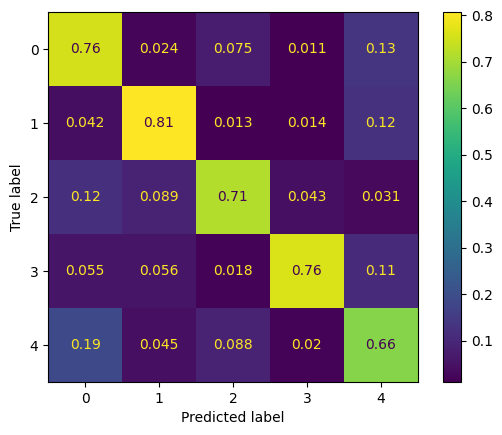

In [91]:
y_pred = model4x20(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().detach().numpy()
print("Accuracy: ",(y_pred.argmax(1) == y_test).sum().item() / len(y_test))
cm = confusion_matrix(y_test, y_pred.argmax(1), normalize='true')
ConfusionMatrixDisplay(cm).plot()

In [92]:
generate_pruned(model4x20, "4_20", 0.1, "-0.1")

/home/samuel/anaconda3/envs/neurodiff/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return forward_call(*args, **kwargs)
/home/samuel/anaconda3/envs/neurodiff/lib/python3.8/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Pruning 0.1
Sequential(
  (0): Linear(in_features=16, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): ReLU()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): ReLU()
  (8): Linear(in_features=20, out_features=5, bias=True)
  (9): Softmax(dim=None)
)
Loss: 0.00011012308630669335; Acc: 0.7446672012830794
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Pruning 0.2
Sequential(
  (0): Linear(in_features=16, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bia

In [101]:
generate_pruned(model4x20, "4_20", 1, "-1")

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Pruning 0.1
Sequential(
  (0): Linear(in_features=16, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): ReLU()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): ReLU()
  (8): Linear(in_features=20, out_features=5, bias=True)
  (9): Softmax(dim=None)
)
Loss: 8.185335524826459e-05; Acc: 0.7451652386780906
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Pruning 0.2
Sequential(
  (0): Linear(in_features=16, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias